In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.integrate import odeint
import numpy as np
from tqdm import tqdm
import math

In [2]:
SEED = 2024

## Creating the network

In [3]:
A = sio.loadmat('./NuRsE/figure3/Figure3_produce/TECB.mat')['A']*2
A.shape

(1550, 1550)

In [4]:
def get_GCC(A, cutoff=2):
    G = nx.from_numpy_matrix(A,
        create_using=nx.DiGraph
    )

    largest_component = max(nx.strongly_connected_components(G), key=len)
    
    GCC_idx = np.array(G.subgraph(largest_component))

    if GCC_idx.shape[0]<cutoff:
        return np.array([])

    A_rows = A[GCC_idx]
    A_gcc = A_rows[:,GCC_idx]

    return A_gcc
    

## Running the Dynamics

In [5]:
def michealis_menten_ODE(values, t, A, B=1, f=1, h=2):
        
    dvalues_dt = -B*np.power(values, f*np.ones(values.size))
    
    vpowh = np.power(values, h*np.ones(values.size))
    dvalues_dt+= np.dot(A,vpowh/(vpowh+1))

    return dvalues_dt

In [6]:
A_gcc = get_GCC(A)

In [7]:
n_nodes = A_gcc.shape[0]
initial_values = np.ones(n_nodes) * 2
print(initial_values.shape)
t = np.arange(0, 10, 0.01)

values = odeint(michealis_menten_ODE, initial_values, t, args=(A_gcc,))

print(values.shape)


(4,)
(1000, 4)


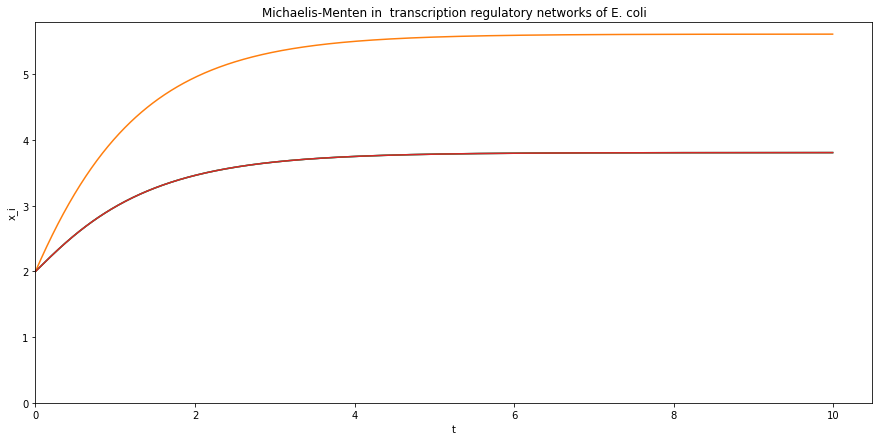

In [8]:
plt.figure(figsize=(15,7))

np.random.seed(SEED)
plot_nodes = np.random.choice(np.arange(values.shape[1]),values.shape[1],replace=False)

plt.plot(t[:], values[:,plot_nodes])
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel('t')
plt.ylabel('x_i')

plt.title('Michaelis-Menten in  transcription regulatory networks of E. coli')

plt.show()

## Removing nodes

In [9]:
def remove_nodes(A, n_rem, seed=SEED):
    if A.shape[0] == 0:
        return A
    
    np.random.seed(seed)
    rem_idx = np.random.choice(np.arange(A.shape[0]), size=n_rem)

    A_rem_row = np.delete(A, rem_idx, 0)
    A_curr = np.delete(A_rem_row, rem_idx, 1)

    return A_curr
    
def get_activity_remnode(A_curr,h=0.01,tf=8):
    t = np.arange(0, tf, h)
    initial_values = np.ones(A_curr.shape[0]) * 2

    values = odeint(michealis_menten_ODE, initial_values, t, args=(A_curr,))

    return np.mean(values[-1])



In [10]:
f_rem = 0.02
nruns = 50

np.random.seed(SEED)
run_seed = np.random.choice(10000, nruns, replace=False)

In [11]:
activities_nruns = []
F_N = []
N_rem = []
max_iter = A.shape[0]

cuttoff = 0.99
for seed in tqdm(run_seed):
    f_n = 0
    activities = []
    A_ret = A
    remove = False
    i = 0
    
    while (seed==run_seed[0] and f_n < cuttoff) or (seed!=run_seed[0] and i<max_iter):
        if(seed==run_seed[0]):
            n_rem = math.ceil(A_ret.shape[0]*f_rem) if remove else 0
            N_rem.append(n_rem)
        
        A_ret = remove_nodes(A_ret, N_rem[i],seed)
        
        if (A_ret.shape[0]!=0):
            A_gcc = get_GCC(A_ret)
            if (A_gcc.shape[0]!=0):
                x_avg = get_activity_remnode(A_gcc,h=0.01, tf=8)
                activities.append(x_avg)
            else:
                activities.append(0)
        else:
            activities.append(0)

        remove = True
        i+= 1

        if(seed==run_seed[0]):
            f_n+= N_rem[-1]/ A.shape[0]
            F_N.append(f_n)
            max_iter = i
    
    activities_nruns.append(activities)
    
    

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


In [12]:
activities_nruns = np.array(activities_nruns)

print(activities_nruns.shape)
print(len(F_N))

(50, 152)
152


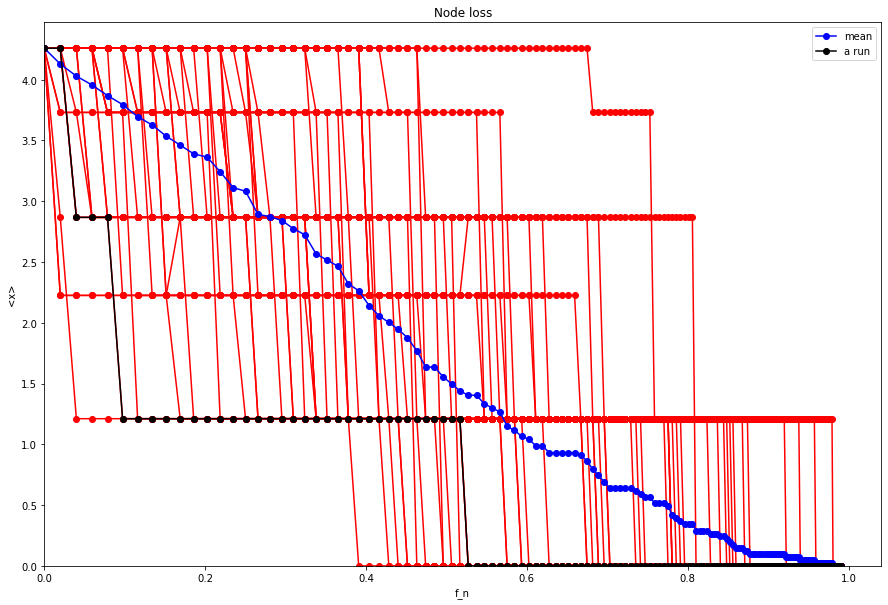

In [13]:
plt.figure(figsize=(15,10))
plt.plot(F_N,activities_nruns.T, 'o-', color='r')
plt.plot(F_N,np.mean(activities_nruns,axis=0), 'o-', color='blue', label='mean')
plt.plot(F_N,activities_nruns[np.random.choice(range(nruns),1)[0]], 'o-', color='black', label='a run')

plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel(f'f_n')
plt.ylabel(f'<x>')
plt.title('Node loss')
plt.legend()

plt.show()